# Data Storytelling - Overview

The purpose of this notebook is to give insight into the total daily solar energy availability (referred to as "energy") and how it changes over time, relates to mesonet station location, elevation, and the weather forecast variables. This analysis is discussed in the document available: https://github.com/connormca12/Springboard-Projects/blob/master/Capstone-1/Capstone%20Project%201%20-%20Data%20Storytelling%20-%20Connor%20McAnuff.pdf

## Questions:
- What are the distributions of Mesonet station location (lat/long) and elevation?
- How do the energy measurements vary over time (month-to-month, year-to-year) for a single station and for all stations combined? For all stations combined, how variable is the data for a given month/year?
- What is the distribution of total energy by station location?
- What are the differences in the energy data of stations in the east of Oklahoma vs the west of Oklahoma?
- How do the total/average of weather forecast variables vary in space and time and how do they relate to the energy?

## Visualizations:
### Station location
1. Mesonet station elevation and location

### Energy Availability
2. ACME station daily energy / ACME station 30-day rolling average daily energy
3. Yearly energy / Monthly energy  (all stations combined)
4. Energy availability distribution by year (all stations combined)
5. Energy availability distribution by month
6. Total energy by station location
7. Average total energy (east - west stations comparison)
8. Total energy distribution (east - west stations comparison) boxplot + violinplot

### Weather Forecast Variables
9. Total forecast precipitation (contour map) with station energy data
10. Total Forecast Downward Short-wave Radiative Flux At Surface (contour map) with station energy data
11. Average Forecast Total Cloud Cover % (contour map) with station energy data
12. Average Forecast Surface Temperature (contour map) with station energy data
13. Total Forecast Precipitation by year
14. Total Forecast Precipitation by month 

# Data Importing

In [1]:
# Import necessary modules

import numpy as np
import netCDF4 as nc
import pandas as pd

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline
from pathlib import Path
import glob
from functools import reduce
import calendar

from mpl_toolkits.basemap import Basemap, cm
import seaborn as sns 

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Import the station location data and station energy data

# Station data is the list of 98 Mesonet solar farm IDs, their location (longitude, latitude, elevation)
stations = pd.read_csv('station_info.csv')

# Energy data is the total daily energy availability on each day for each station
energy = pd.read_csv('train.csv', parse_dates=True, index_col='Date')

In [3]:
# Import the weather variable forecasts
# Forecasts are separated into 15 different files for each forecast variable (e.g. air pressure, specific humidity, etc.)
# Each variable is forecast using 11 different predictive models at 144 gridpoint locations
# (on 16 lines of longitude and 9 lines of latitude)

# Take any filename that ends in .nc and add to a list of the files
weather_file_list = glob.glob('*.nc')

# Take the data from each file in the file list and put into a list of data
list_of_data = [xr.open_dataset(filename) for filename in weather_file_list]

# Convert list of data to a list of dataframes
# Each dataframe consists of forecast data for a single weather variable
list_of_dfs = [data_file.to_dataframe() for data_file in list_of_data]

In [4]:
# Load previously organized data - includes energy availability for each day at each station and the associated weather
# variable forecasts
EDA_data = pd.read_csv('ML_dataset_filtered.csv')

In [5]:
def basic_oklahoma_map(ax=None, lllat=34, urlat=42,
                   lllon=-45, urlon=-75):
    '''
    Function for creating basemap object - adapted from: https://github.com/joelmpiper/solar_energy_prediction/blob/master/notebooks/slides/FinalPresentation.ipynb
    '''
    m = Basemap(ax=ax, projection='stere', lon_0=(urlon + lllon)/2,
               lat_0=(urlat + lllat) / 2, llcrnrlat = lllat, urcrnrlat=urlat,
               llcrnrlon=lllon, urcrnrlon=urlon,
               resolution='f')
    m.drawstates()
    return m

# Station Location and Elevation

In [6]:
print('Maximum Elevation: ' + str(max(stations['elev'].values)))
print('Minimum Elevation: ' + str(min(stations['elev'].values)))
print('Elevation Change: ' + str(max(stations['elev'].values) - min(stations['elev'].values)))

Maximum Elevation: 1322
Minimum Elevation: 110
Elevation Change: 1212


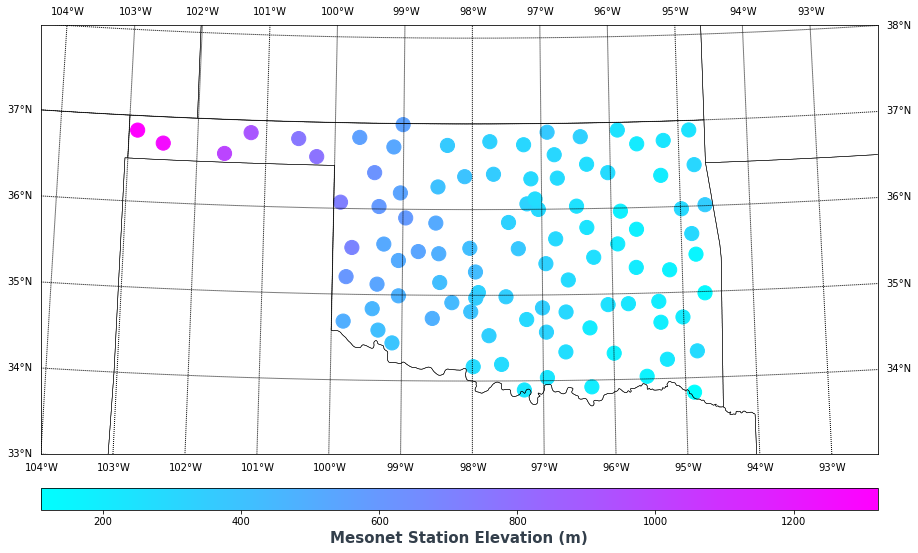

In [7]:
# Initialize figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Plot map outline and lines of latitude/longitude
lllat=33; urlat=38; lllon=-104; urlon=-92
ax = axes
m = basic_oklahoma_map(ax, lllat=lllat, urlat=urlat, lllon=lllon, urlon=urlon)
parallels = np.arange(30.,40,1.)
m.drawparallels(parallels,labels=[1,1,0,0],fontsize=10)
meridians = np.arange(-104.,-92.,1.)
m.drawmeridians(meridians,labels=[0,0,1,1],fontsize=10)

# Load station data (location and elevation)
data = stations['elev'].values
lons = stations['elon']
lats = stations['nlat']
x, y = m(lons.values, lats.values)

# Plot station locations coloured by elevation
cs = m.scatter(x,y, s=200, c=data, cmap='cool')

# Add colourbar
cbar = m.colorbar(cs,location='bottom',pad="8%")
cbar.set_label(r'Mesonet Station Elevation (m)', fontsize=15, fontweight='black', color = '#333F4B')

plt.savefig('mesonet_station_elevation', bbox_inches='tight', pad_inches=0.5)

plt.show()

### Figure 1 Discussion:
- Stations are spread evenly across Oklahoma.
- 1212 m range in station elevation.
- The elevation of the stations steadily increases from east to west. This trend is indicative of Oklahoma’s variable geography. The eastern side of Oklahoma is lower and contains extensive forested areas. Central Oklahoma contains a transition from forest to prairies and in the north-west there are flat grasslands.

# Single Station Energy Availability

C:\Users\conno\Anaconda3\envs\Springboard\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


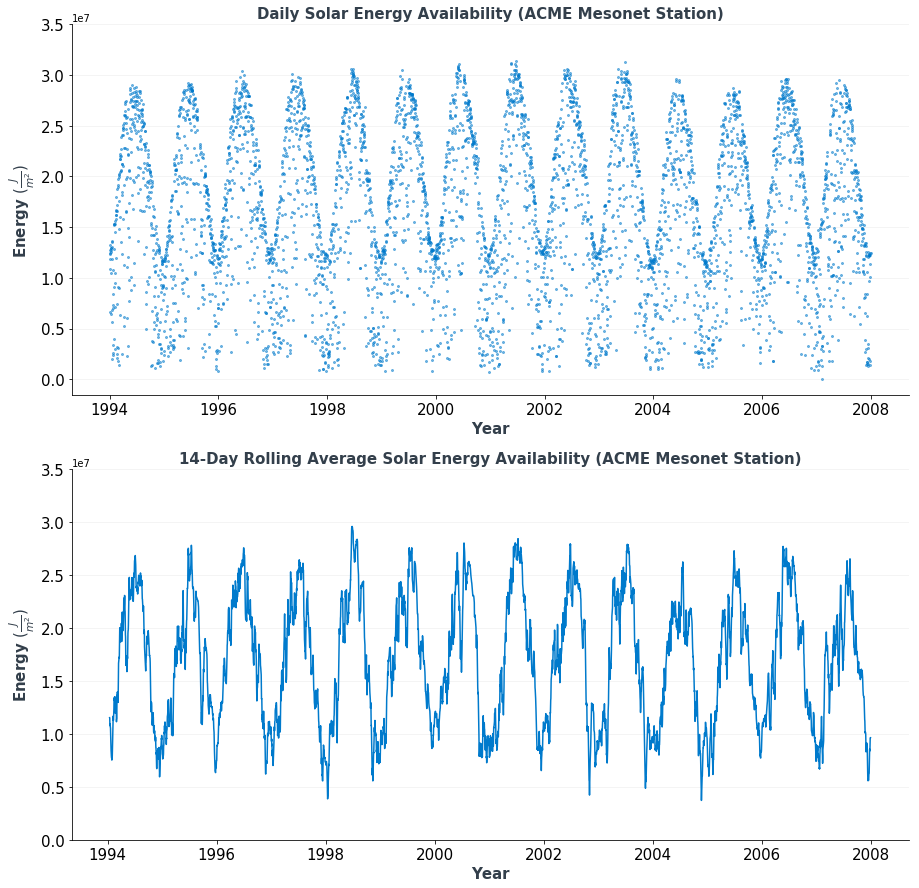

In [9]:
# Extract ACME energy data 
EDA_ACME = EDA_data[EDA_data['stid'] == 'ACME'].reset_index(drop=True)
#del EDA_ACME['index']
EDA_ACME['Date'] = pd.to_datetime(EDA_ACME['Date'])

# Calculate the 14-day rolling average energy availability at ACME station
ACME_rolling = EDA_ACME.iloc[:,0:3]
del ACME_rolling['stid']
ACME_rolling = ACME_rolling.set_index('Date')
ACME_rolling['trailing_avg'] = ACME_rolling['energy'].rolling(window=14).mean()

# Initialize figure and axes
fig, ax = plt.subplots(2, 1, figsize=(15,15))

# Plot the daily energy availability 
ax[0].plot(EDA_ACME['Date'], EDA_ACME['energy'], "o", markersize=2, color='#007acc', alpha=0.5)

# Plot the 14-day rolling average energy availability
ax[1].plot(ACME_rolling['trailing_avg'], color='#007acc', alpha=1)

# Set titles
ax[0].set_title("Daily Solar Energy Availability (ACME Mesonet Station)", fontsize=15, fontweight='black', color = '#333F4B')
ax[1].set_title("14-Day Rolling Average Solar Energy Availability (ACME Mesonet Station)", fontsize=15, fontweight='black', color = '#333F4B')

# Set axis customizations
ind = np.arange(0, 40000000, 5000000)
for i in range(len(ax)):

    ax[i].set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
    ax[i].set_ylabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

    ax[i].set_facecolor('white')
    ax[i].grid(color='grey', alpha=0.1)
    ax[i].xaxis.grid(False)
    ax[i].set_axisbelow(True)
    
    ax[i].set_yticks(ind)
    ax[i].tick_params(labelsize=15)

    ax[i].spines['top'].set_color('none')
    ax[i].spines['right'].set_color('none')

plt.savefig('Figures/acme_daily_solar', bbox_inches='tight', pad_inches=0.5)    

plt.show()

### Figure 2 Discussion:
- Daily energy availability is cyclical - Energy peaks yearly during June/July and troughs during December/January. This trend is expected, as Oklahoma is significantly north of the equator, thus from December 21 to June 21, the sun's time and height above the horizon increase (and vice versa).
    - It would be interesting to compare a spline fit to the uppermost data points (e.g. of each two-week period) to the theoretical curve of solar energy availability at the same location.
- Data appears similar from year to year.
- There appears to be significant variability within short periods of time along the entire 14-year span.


# Combined Station Energy Availability

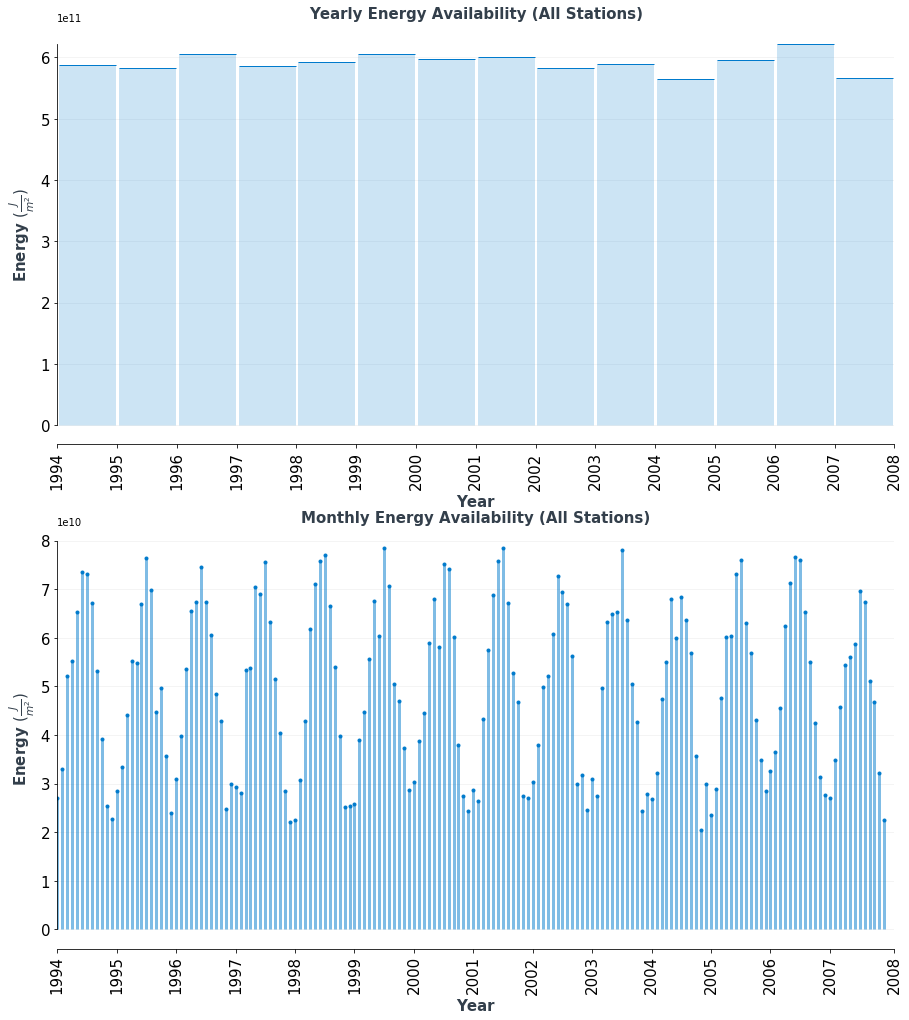

In [16]:
# Resample the energy data to sum for each year
total_energy_yearly = energy.resample('A').sum().sum(axis=1)

# Resample the energy data to sum for each month
total_energy_monthly = energy.resample('M').sum().sum(axis=1)

# Initialize figures and axes
fig, ax = plt.subplots(2, 1, figsize=(15,17))

# Initialize x locations and shift to the right to have the yearly bars line up with the years of the monthly chart
my_range=list(range(0,len(total_energy_yearly.index)))
my_range.append(14)
my_rangetemp = []
for i in range(len(my_range)):
    my_rangetemp.append(my_range[i] + 0.5)
    
# Plot bar lines for yearly data
ax[0].vlines(x=my_rangetemp, ymin=0, ymax=total_energy_yearly, color='#007acc', alpha=0.2, linewidth=57)

# Use total_energy without extra value for lines at top of yearly bars
my_rangetemp.pop()

# Plot accent line at top of yearly bars
ax[0].plot(my_rangetemp, total_energy_yearly, "_", markersize=57, color='#007acc', alpha=1)

# Initialize x locations for monthly data
my_range2=list(range(0,len(total_energy_monthly.index)))

# Plot bar lines for monthly data
ax[1].vlines(x=my_range2, ymin=0, ymax=total_energy_monthly, color='#007acc', alpha=0.5, linewidth=3)

# Plot accent circle at top of monthly bars
ax[1].plot(my_range2, total_energy_monthly, "o", markersize=3, color='#007acc', alpha=1)

# Set titles and axes labels
ax[0].set_title("Yearly Energy Availability (All Stations)", fontsize=15, fontweight='black', color = '#333F4B')
ax[0].set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
ax[0].set_ylabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

ax[1].set_title("Monthly Energy Availability (All Stations)", fontsize=15, fontweight='black', color = '#333F4B')
ax[1].set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
ax[1].set_ylabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

# Set axes customizations
ind = np.arange(len(total_energy_yearly)+1)
ax[0].set_xticks(ind)
ax[0].set_xticklabels(('1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008'), rotation=90, fontsize=15)

ind2 = np.arange(0, len(total_energy_monthly)+12, 12)
ind2[-1] = 169
ax[1].set_xticks(ind2)
ax[1].set_xticklabels(('1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008'), rotation=90, fontsize=15)

ax[0].set_xlim(left = 0, right=14)
ax[1].set_xlim(left = 0, right=169)

for i in list(range(0,2)):

    ax[i].set_facecolor('white')
          
    ax[i].grid(color='grey', alpha=0.1)
    ax[i].xaxis.grid(False)
    ax[i].set_axisbelow(True)
    
    ax[i].tick_params(labelsize=15)
    
    ax[i].spines['top'].set_color('none')
    ax[i].spines['right'].set_color('none')
    ax[i].spines['left'].set_smart_bounds(True)
    ax[i].spines['bottom'].set_smart_bounds(True)

plt.savefig('Figures/yearly_energy_all_stations', bbox_inches='tight', pad_inches=0.5)
    
plt.show()

### Figure 3 Discussion:
- Across years, total energy appears consistent 
- In the monthly chart, we see the same cyclical trend of the data as was seen in the ACME station plots

In [13]:
# Extract daily energy and label by year
energy_dist = EDA_data
energy_dist = energy_dist.set_index(pd.DatetimeIndex(energy_dist['Date']))
#del energy_dist['index']
del energy_dist['Date']
energy_dist = energy_dist.iloc[:,0:2].reset_index()
energy_dist['year'] = energy_dist.Date.apply(lambda x: x.strftime('%Y'))
del energy_dist['Date']
del energy_dist['stid']

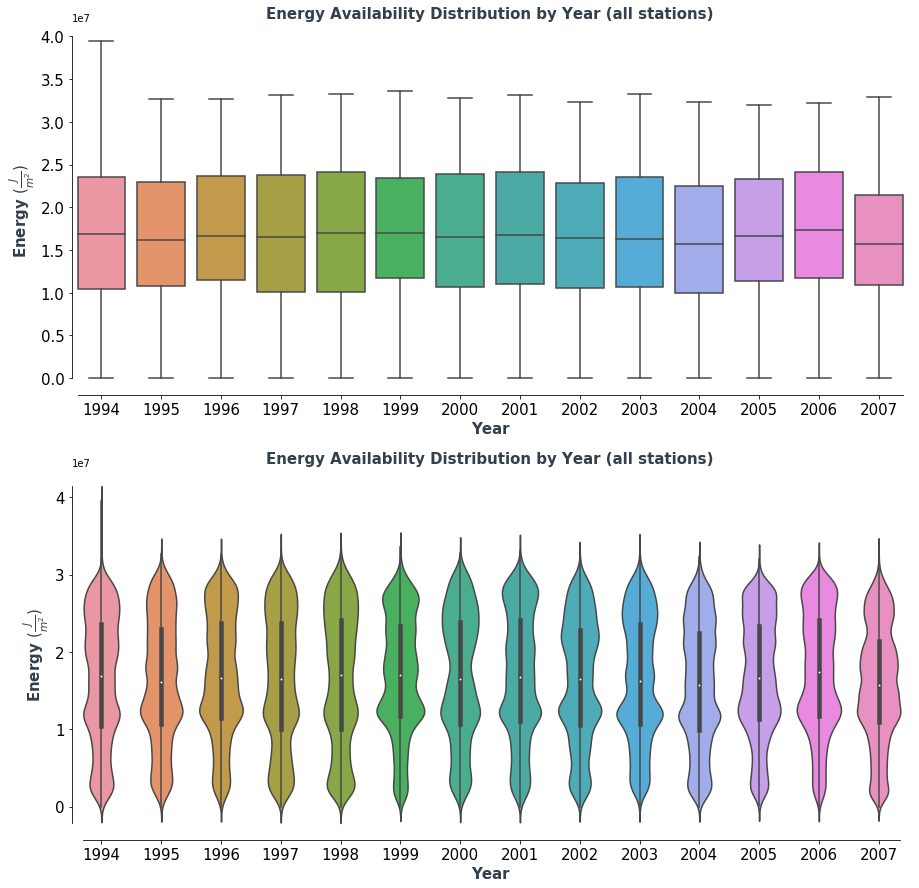

In [15]:
# Initialize figures and axes
fig, ax = plt.subplots(2, 1, figsize=(15,15))

# Plot boxplot
sns.boxplot(ax=ax[0], y='energy', x='year', data=energy_dist)

# Plot violinplot
sns.violinplot(ax=ax[1], y='energy', x='year', data=energy_dist)

# Set axes customizations
for i in range(len(ax)):
    
    ax[i].set_title("Energy Availability Distribution by Year (all stations)", fontsize=15, fontweight='black', color = '#333F4B')
    ax[i].set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
    ax[i].set_ylabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

    ax[i].tick_params(labelsize=15)

    ax[i].spines['top'].set_color('none')
    ax[i].spines['right'].set_color('none')
    ax[i].spines['left'].set_smart_bounds(True)
    ax[i].spines['bottom'].set_smart_bounds(True)

plt.savefig('Figures/yearly_energy_distribution_all_stations', bbox_inches='tight', pad_inches=0.5)
    
plt.show()

### Figure 4 Discussion:
- Across years distribution of daily energy appears consistent.
- 1994 maximum whisker position is from a single data point discussed after the next figure.


In [19]:
# Extract daily energy and label by month
energy_monthly = EDA_data
energy_monthly = energy_monthly.set_index(pd.DatetimeIndex(energy_monthly['Date']))
#del energy_monthly['index']
del energy_monthly['Date']
energy_monthly = energy_monthly.iloc[:,0:2].reset_index()
energy_monthly['month'] = energy_monthly.Date.apply(lambda x: x.strftime('%b'))
del energy_monthly['Date']
del energy_monthly['stid']

In [20]:
energy_sorted = energy_monthly.sort_values(by='energy')
print(energy_sorted.head(5))
print(energy_sorted.tail(5))
energy_april = energy_monthly[energy_monthly['month'] == 'Apr']
print(energy_april.sort_values(by='energy').tail(5))
EDA_data.iloc[223983,:].head(7)

        energy month
248885     300   Jan
28666      300   Oct
79266      300   Jan
352525     300   Oct
330161     300   Feb
          energy month
215058  33293700   Jun
237291  33303900   Jun
215057  33304200   Jun
215411  33578400   Jun
223736  39442800   Apr
          energy month
401190  31292700   Apr
237254  31356000   Apr
401193  31812300   Apr
223730  32855400   Apr
223736  39442800   Apr


Date               1994-12-10
stid                     IDAB
energy               12074100
nlat                  33.8301
elon                   265.12
elev                      110
apcp_sfc_fhour0          0.19
Name: 223983, dtype: object

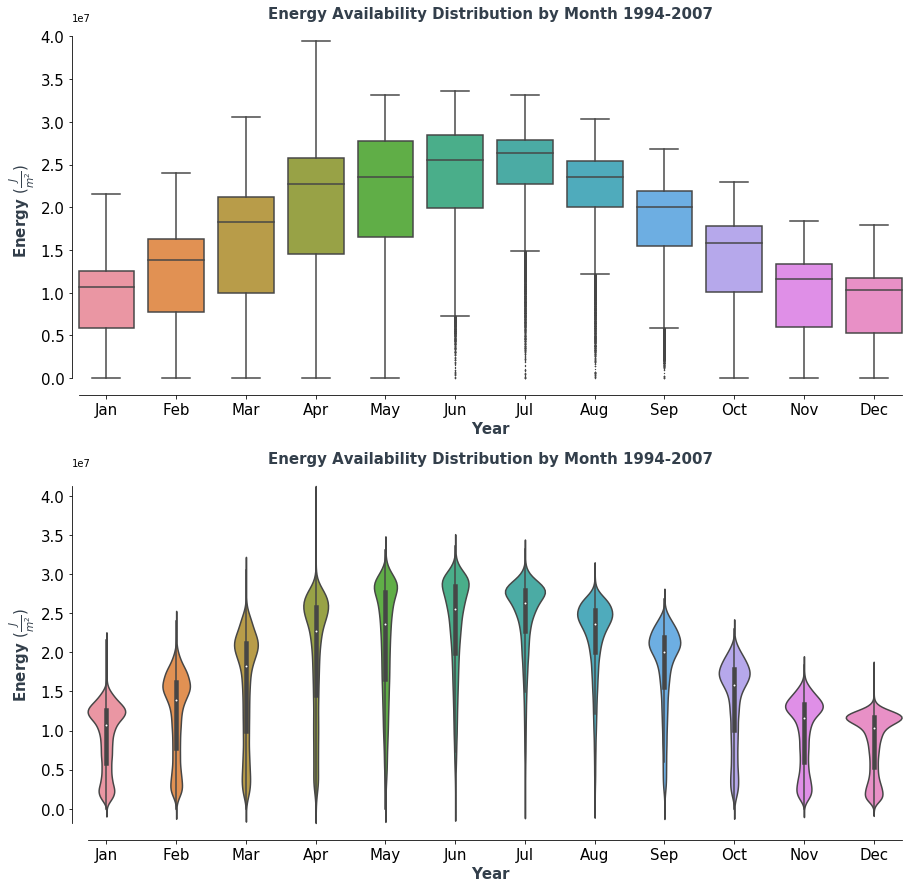

In [21]:
# Initialize figures and axes
fig, ax = plt.subplots(2, 1, figsize=(15,15))

# Plot boxplot
flierprops = dict(markerfacecolor='0.75', markersize=0.5, linestyle='none')
sns.boxplot(ax=ax[0], y='energy', x='month', data=energy_monthly, flierprops=flierprops)

# Plot violinplot
sns.violinplot(ax=ax[1], y='energy', x='month', data=energy_monthly)

# Set axes customizations
ind = np.arange(0, 45000000, 5000000)
for i in range(len(ax)):
    
    ax[i].set_title("Energy Availability Distribution by Month 1994-2007", fontsize=15, fontweight='black', color = '#333F4B')
    ax[i].set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
    ax[i].set_ylabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

    ax[i].tick_params(labelsize=15)
    ax[i].set_yticks(ind)
    
    ax[i].spines['top'].set_color('none')
    ax[i].spines['right'].set_color('none')
    ax[i].spines['left'].set_smart_bounds(True)
    ax[i].spines['bottom'].set_smart_bounds(True)

plt.savefig('Figures/monthly_total_energy_distribution_all_stations', bbox_inches='tight', pad_inches=0.5)    

plt.show()

### Figure 5 Discussion:
- NOTE: there are no 0s - lowest is 300 and highest is 39442800 (100,000x the magnitude)
- June, July, August have significantly fewer low values (thus they are shown as outliers on the boxplot as opposed to within the whiskers)
- Violin plot shows:
    - June, July, August distribution as mainly high values with a low end tail
    - May, September distribution also mainly high values but a slightly more robust low end tail
    - April, October distribution, the low end tail begins to change into a larger concentration
    - November - March distributions are bimodal, with a larger percentage of values being at the high value peak
- April has the greatest spread of values (perhaps inconsistent weather patterns?)
- The median value of each month is consistent with the theoretical solar energy availability 
- The lower sections of the box and whiskers are longer than the upper sections, indicating that the higher values have lower variance than the lower values (can also be seen on the violin plot)

# Energy Availability by Station

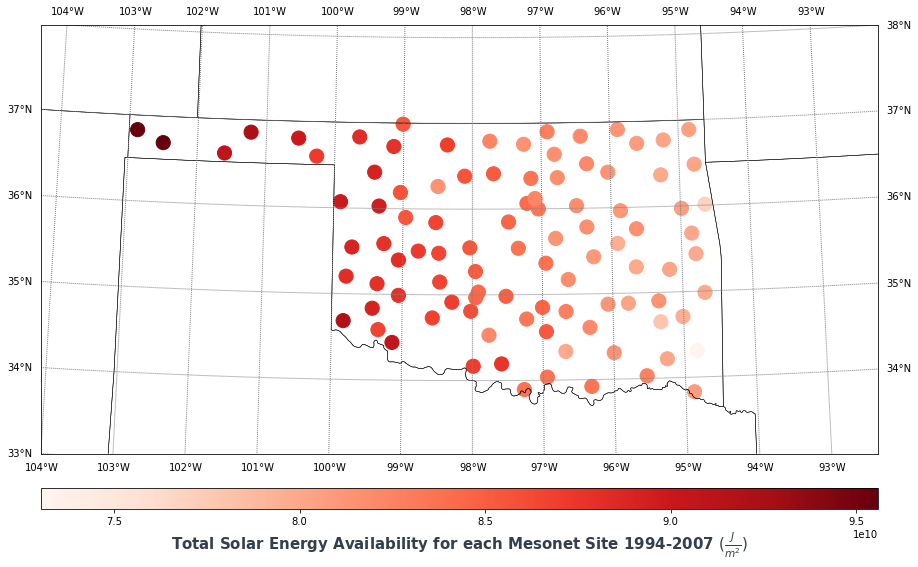

In [22]:
# Sum total energy availability of each station and merge with station info
energy_sum = EDA_data.groupby(by='stid').sum()['energy']
energy_sum = pd.merge(energy_sum, stations, on='stid')

# Initialize figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Plot map outline and lines of latitude/longitude
lllat=33; urlat=38; lllon=-104; urlon=-92
ax = axes
m = basic_oklahoma_map(ax, lllat=lllat, urlat=urlat, lllon=lllon, urlon=urlon)
parallels = np.arange(30.,40,1.)
m.drawparallels(parallels,labels=[1,1,0,0],fontsize=10, color='grey')
meridians = np.arange(-104.,-92.,1.)
m.drawmeridians(meridians,labels=[0,0,1,1],fontsize=10, color='grey')

# Load energy data and gridpoint locations
data = energy_sum['energy'].values
lons = energy_sum['elon']
lats = energy_sum['nlat']
x, y = m(lons.values, lats.values)

# Plot filled contours
cs = m.scatter(x,y, s=200, c=data, cmap='Reds')

# Add colourbar
cbar = m.colorbar(cs,location='bottom',pad="8%")
cbar.set_label(r'Total Solar Energy Availability for each Mesonet Site 1994-2007 $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

plt.savefig('Figures/total_energy_stations_map', bbox_inches='tight', pad_inches=0.5)   

plt.show()

### Figure 6 Discussion:
- There is a clear east to west trend of increasing total solar energy availability
- The geography/vegetation of Oklahoma varies from east to west as well:
    - The eastern side is lower and contains extensive forested areas
    - Central Oklahoma contains a transition from forests to prairies
    - In the north-west there are flat grasslands

# East - West Stations Comparison

In [16]:
# Split stations at 98 deg W line of longitude
energy_sum_east = EDA_data[EDA_data['elon'] > 262]
del energy_sum_east['index']
energy_sum_east = energy_sum_east.set_index(pd.DatetimeIndex(energy_sum_east['Date']))

energy_sum_west = EDA_data[EDA_data['elon'] < 262]
del energy_sum_west['index']
energy_sum_west = energy_sum_west.set_index(pd.DatetimeIndex(energy_sum_west['Date']))

# Resample the energy data to average the east/west stations for each year
energy_sum_east = energy_sum_east.resample('A').mean()['energy']
energy_sum_west = energy_sum_west.resample('A').mean()['energy']

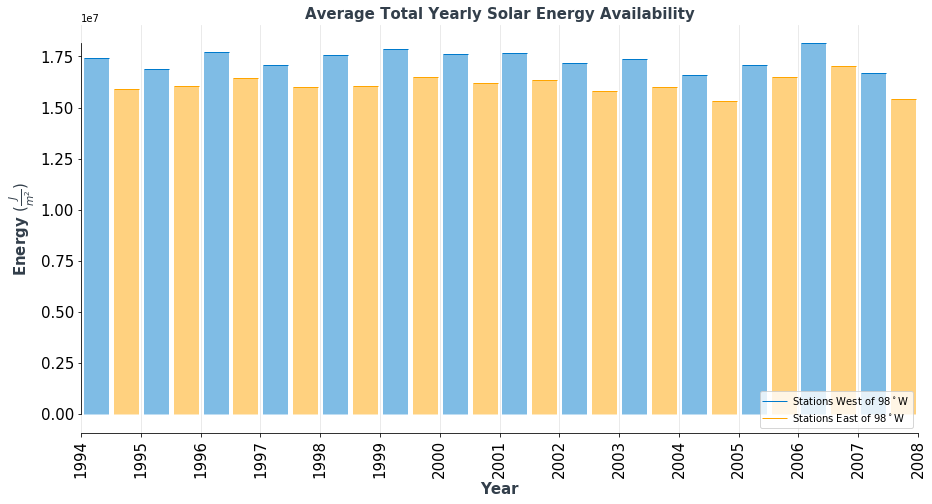

In [17]:
# Initialize figures and axes
fig, ax = plt.subplots(figsize=(15,7.5))

# Initialize x locations for west data
my_range=list(range(0,len(energy_sum_east.index)))
for i in range(len(my_range)):
    my_range[i] = my_range[i] + 0.25
    
# Plot bar lines for west data
ax.vlines(x=my_range, ymin=0, ymax=energy_sum_west, color='#007acc', alpha=0.5, linewidth=25)

# Plot accent line at top of west bars
ax.plot(my_range, energy_sum_west, "_", markersize=25, color='#007acc', alpha=1)

# Initialize x locations for east data
my_range2 = []
for i in range(len(my_range)):
    my_range2.append(my_range[i] + 0.5)

# Plot bar lines for east data
ax.vlines(x=my_range2, ymin=0, ymax=energy_sum_east, color='orange', alpha=0.5, linewidth=25)

# Plot accent circle at top of east bars
ax.plot(my_range2, energy_sum_east, "_", markersize=25, color='orange', alpha=1)

# Set titles and axes labels
ax.set_title("Average Total Yearly Solar Energy Availability", fontsize=15, fontweight='black', color = '#333F4B')
ax.set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

# Set axes customizations
ax.set_facecolor('white')

ind = np.arange(len(total_energy_yearly)+1)
ax.set_xticks(ind)
ax.set_xticklabels(('1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008'), rotation=90, fontsize=15)

ax.set_xlim(left = 0, right=14)

ax.grid(color='grey', alpha=0.2)
ax.yaxis.grid(False)
ax.set_axisbelow(True)

ax.tick_params(labelsize=15)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

ax.legend(('Stations West of 98$^\circ$W', 'Stations East of 98$^\circ$W'), loc='lower right')

plt.show()

### Figure 7 Discussion:
- Western stations have higher energy than eastern stations every year
- The difference between east and west stations appears consistent every year

In [18]:
# East-west energy availability distributions

# Extract station energy data east of 98 deg W
energy_east = EDA_data[EDA_data['elon'] > 262]
energy_east = energy_east.set_index(pd.DatetimeIndex(energy_east['Date']))
del energy_east['index']
del energy_east['Date']
energy_east = energy_east.iloc[:,0:2].reset_index()
energy_east['year'] = energy_east.Date.apply(lambda x: x.strftime('%Y'))
del energy_east['Date']
del energy_east['stid']
energy_east['split'] = 'East of 49W'

# Extract station energy data west of 98 deg W
energy_west = EDA_data[EDA_data['elon'] < 262]
energy_west = energy_west.set_index(pd.DatetimeIndex(energy_west['Date']))
del energy_west['index']
del energy_west['Date']
energy_west = energy_west.iloc[:,0:2].reset_index()
energy_west['year'] = energy_west.Date.apply(lambda x: x.strftime('%Y'))
del energy_west['Date']
del energy_west['stid']
energy_west['split'] = 'West of 49W'

# Combine into single DataFrame
energy_split = pd.concat([energy_west, energy_east])

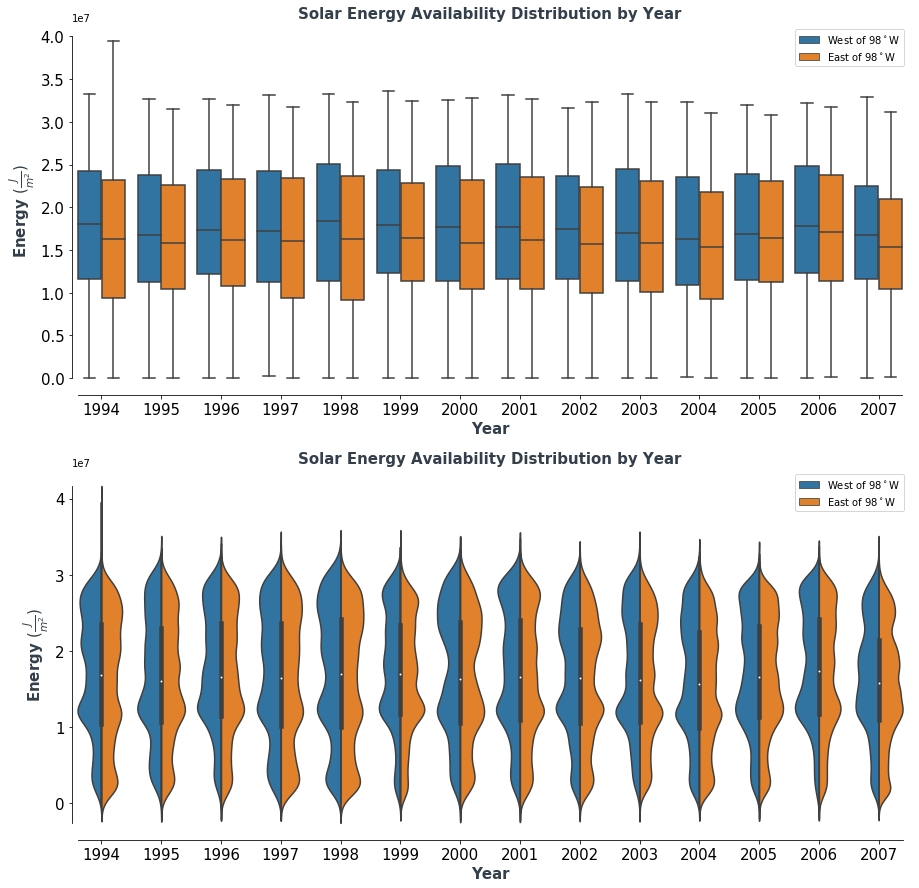

In [19]:
# Initialize figures and axes
fig, ax = plt.subplots(2, 1, figsize=(15,15))

# Plot boxplot
sns.boxplot(ax=ax[0], y='energy', x='year', hue='split', data=energy_split)

# Plot violinplot
sns.violinplot(ax=ax[1], y='energy', x='year', hue='split', data=energy_split, split=True)

# Set axes customizations
for i in range(len(ax)):
    
    ax[i].set_title("Solar Energy Availability Distribution by Year", fontsize=15, fontweight='black', color = '#333F4B')
    ax[i].set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
    ax[i].set_ylabel(r'Energy $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

    legend = ax[i].legend()
    legend.texts[0].set_text("West of 98$^\circ$W")
    legend.texts[1].set_text("East of 98$^\circ$W")

    ax[i].tick_params(labelsize=15)

    ax[i].spines['top'].set_color('none')
    ax[i].spines['right'].set_color('none')
    ax[i].spines['left'].set_smart_bounds(True)
    ax[i].spines['bottom'].set_smart_bounds(True)

plt.show()

### Figure 8 Discussion:
- Years have consistent distributions except for 1994 (eastern stations)
- 1994 data in the eastern stations has more variance than any other year
- Violin plot shows peaks at 2.75e7 (summer peak), 1.25e7 (winter peak), and 0.25e7 (winter minimum)

# Weather Forecast Variables with station energy data

In [20]:
# Total forecast precipitation (1994-2007)

# Load weather forecast data
total_prec = pd.DataFrame(list_of_dfs[0])
total_prec = total_prec.iloc[:, 2]
total_prec = total_prec.reset_index().set_index('time')

# Take the median of the 11 predictive models
total_prec = total_prec.groupby(by=['time','fhour', 'lat', 'lon']).median()
del total_prec['ens']

# Take the average value at each gridpoint
total_prec = total_prec.groupby(by=['lat', 'lon']).sum()
total_prec = total_prec.reset_index()

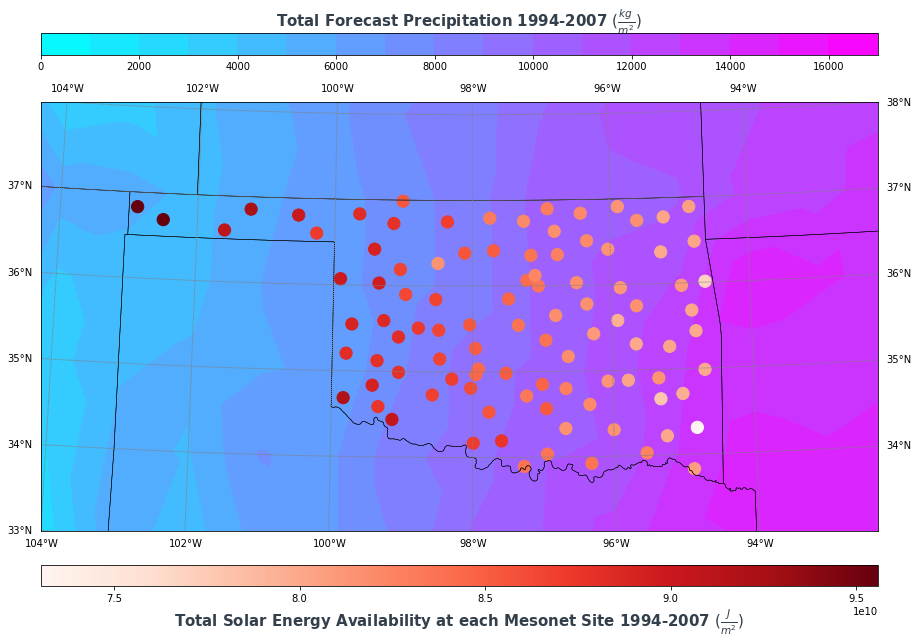

In [21]:
# Initialize figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,20))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Plot map outline and lines of latitude/longitude
lllat=33; urlat=38; lllon=-104; urlon=-92
ax = axes
m = basic_oklahoma_map(ax, lllat=lllat, urlat=urlat, lllon=lllon, urlon=urlon)
parallels = np.arange(30.,40,1.)
m.drawparallels(parallels,labels=[1,1,0,0],fontsize=10, color='grey')
meridians = np.arange(-104.,-92.,2.)
m.drawmeridians(meridians,labels=[0,0,1,1],fontsize=10, color='grey')

# Load weather forecast data and gridpoint locations
data = total_prec['Total_precipitation'].values
lons = total_prec['lon']
lats = total_prec['lat']
x, y = m(lons.values, lats.values)

# Plot filled contours
clevs = range(0,18000,1000)
cs = plt.tricontourf(x,y,data,clevs,cmap='cool')

# Add colourbar
cbar = m.colorbar(cs,location='top',pad="40%")
cbar.set_label(r'Total Forecast Precipitation 1994-2007 $(\frac{kg}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B', labelpad=-65, y=1)

# Load energy data and gridpoint locations
data = energy_sum['energy'].values
lons = energy_sum['elon']
lats = energy_sum['nlat']
x, y = m(lons.values, lats.values)

# Plot scatter points
cs = m.scatter(x,y, s=150, c=data, cmap='Reds')

# Add energy data colourbar
cbar = m.colorbar(cs,location='bottom',pad="8%")
cbar.set_label(r'Total Solar Energy Availability at each Mesonet Site 1994-2007 $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')


plt.show()

### Figure 9 Discussion:
- Total forecast precipitation increases from west to east. As expected, it is inversely correlated to solar energy availability.

In [24]:
# Average forecast cloud cover percentage (1994-2007)

# Load weather forecast data
avg_cloud_cover = pd.DataFrame(list_of_dfs[6])
avg_cloud_cover = avg_cloud_cover.iloc[:, 2]
avg_cloud_cover = avg_cloud_cover.reset_index().set_index('time')

# Take the median of the 11 predictive models
avg_cloud_cover = avg_cloud_cover.groupby(by=['time','fhour', 'lat', 'lon']).median()
del avg_cloud_cover['ens']

# Take the average value at each gridpoint
avg_cloud_cover = avg_cloud_cover.groupby(by=['lat', 'lon']).mean()
avg_cloud_cover = avg_cloud_cover.reset_index()

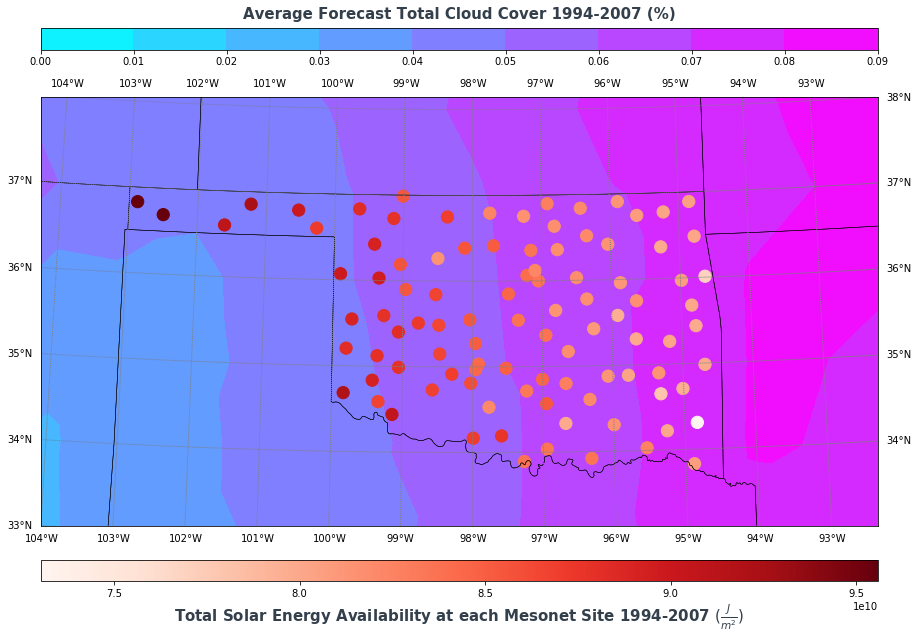

In [25]:
# Initialize figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,20))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Plot map outline and lines of latitude/longitude
lllat=33; urlat=38; lllon=-104; urlon=-92
ax = axes
m = basic_oklahoma_map(ax, lllat=lllat, urlat=urlat, lllon=lllon, urlon=urlon)
parallels = np.arange(30.,40,1.)
m.drawparallels(parallels,labels=[1,1,0,0],fontsize=10, color='grey')
meridians = np.arange(-104.,-92.,1.)
m.drawmeridians(meridians,labels=[0,0,1,1],fontsize=10, color='grey')

# Load weather forecast data and gridpoint locations
data = avg_cloud_cover['Total_cloud_cover'].values
lons = avg_cloud_cover['lon']
lats = avg_cloud_cover['lat']
x, y = m(lons.values, lats.values)

# Plot filled contours
clevs = np.arange(0,0.1,0.01)
cs = plt.tricontourf(x,y,data,clevs,cmap='cool')

# Add colourbar
cbar = m.colorbar(cs,location='top',pad="40%")
cbar.set_label(r'Average Forecast Total Cloud Cover 1994-2007 (%)', fontsize=15, fontweight='black', color = '#333F4B', labelpad=-60, y=1)

# Load energy data and gridpoint locations
data = energy_sum['energy'].values
lons = energy_sum['elon']
lats = energy_sum['nlat']
x, y = m(lons.values, lats.values)

# Plot scatter points
cs = m.scatter(x,y, s=150, c=data, cmap='Reds')

# Add energy data colourbar
cbar = m.colorbar(cs,location='bottom',pad="8%")
cbar.set_label(r'Total Solar Energy Availability at each Mesonet Site 1994-2007 $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

plt.savefig('Figures/average_forecast_cloud_cover_map', bbox_inches='tight', pad_inches=0.5) 

plt.show()

### Figure 10 Discussion:
- As expected, average forecast total cloud cover is similar to total forecast precipitation, increasing from west to east. It is inversely correlated to solar energy availability.

In [27]:
# Total forecast downward short-wave radiative flux (1994-2007)

# Load weather forecast data
total_shortwave_rad = pd.DataFrame(list_of_dfs[2])
total_shortwave_rad = total_shortwave_rad.iloc[:, 2]
total_shortwave_rad = total_shortwave_rad.reset_index().set_index('time')

# Take the median of the 11 predictive models
total_shortwave_rad = total_shortwave_rad.groupby(by=['time','fhour', 'lat', 'lon']).median()
del total_shortwave_rad['ens']

# Take the total value at each gridpoint
total_shortwave_rad = total_shortwave_rad.groupby(by=['lat', 'lon']).sum()
total_shortwave_rad = total_shortwave_rad.reset_index()

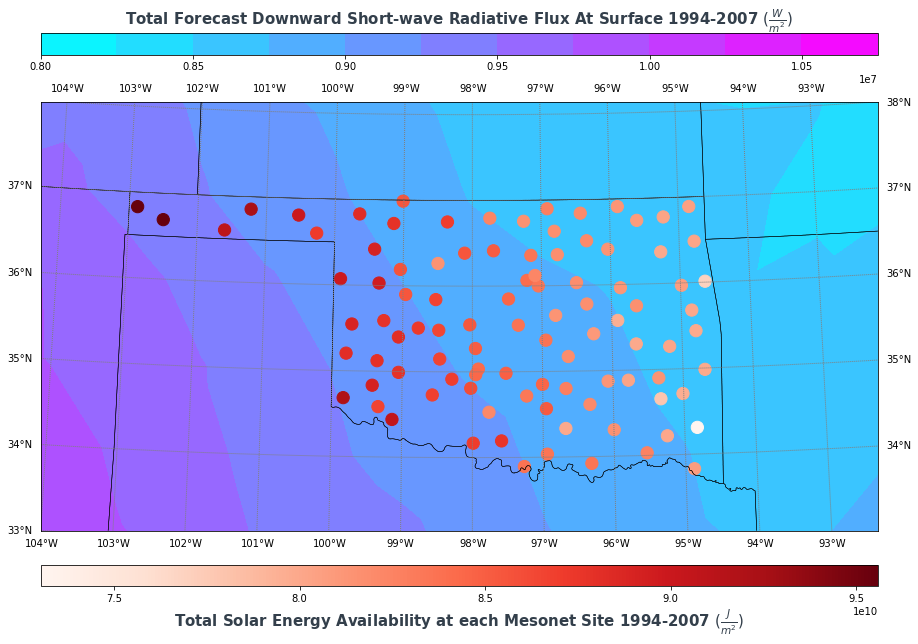

In [28]:
# Initialize figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,20))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Plot map outline and lines of latitude/longitude
lllat=33; urlat=38; lllon=-104; urlon=-92
ax = axes
m = basic_oklahoma_map(ax, lllat=lllat, urlat=urlat, lllon=lllon, urlon=urlon)
parallels = np.arange(30.,40,1.)
m.drawparallels(parallels,labels=[1,1,0,0],fontsize=10, color='grey')
meridians = np.arange(-104.,-92.,1.)
m.drawmeridians(meridians,labels=[0,0,1,1],fontsize=10, color='grey')

# Load weather forecast data and gridpoint locations
data = total_shortwave_rad['Downward_Short-Wave_Rad_Flux'].values
lons = total_shortwave_rad['lon']
lats = total_shortwave_rad['lat']
x, y = m(lons.values, lats.values)

# Plot filled contours
clevs = range(8000000,11000000,250000)
cs = plt.tricontourf(x,y,data,clevs,cmap='cool')

# Add colourbar
cbar = m.colorbar(cs,location='top',pad="40%")
cbar.set_label(r'Total Forecast Downward Short-wave Radiative Flux At Surface 1994-2007 $(\frac{W}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B', labelpad=-65, y=1)

# Load energy data and gridpoint locations
data = energy_sum['energy'].values
lons = energy_sum['elon']
lats = energy_sum['nlat']
x, y = m(lons.values, lats.values)

# Plot scatter points
cs = m.scatter(x,y, s=150, c=data, cmap='Reds')

# Add energy data colourbar
cbar = m.colorbar(cs,location='bottom',pad="8%")
cbar.set_label(r'Total Solar Energy Availability at each Mesonet Site 1994-2007 $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

plt.savefig('Figures/total_forecast_shortwave_flux_map', bbox_inches='tight', pad_inches=0.5) 

plt.show()

### Figure 11 Discussion:
- Total forecast downward short-wave radiative flux increases from west to east, with a slight north-south rotation (more southern areas have increased radiative flux). It is correlated with solar energy availability. 

In [26]:
# Average forecast surface temperature (1994-2007) (with station energy)

# Load weather forecast data
avg_temp = pd.DataFrame(list_of_dfs[11])
avg_temp = avg_temp.iloc[:, 2]
avg_temp = avg_temp.reset_index().set_index('time')

# Take the median of the 11 predictive models
avg_temp = avg_temp.groupby(by=['time','fhour', 'lat', 'lon']).median()
del avg_temp['ens']

# Take the average value at each gridpoint
avg_temp = avg_temp.groupby(by=['lat', 'lon']).mean()
avg_temp = avg_temp.reset_index()

# Convert kelvin to deg. celcius 
avg_temp['Temperature_surface'] = avg_temp['Temperature_surface'] - 273.15

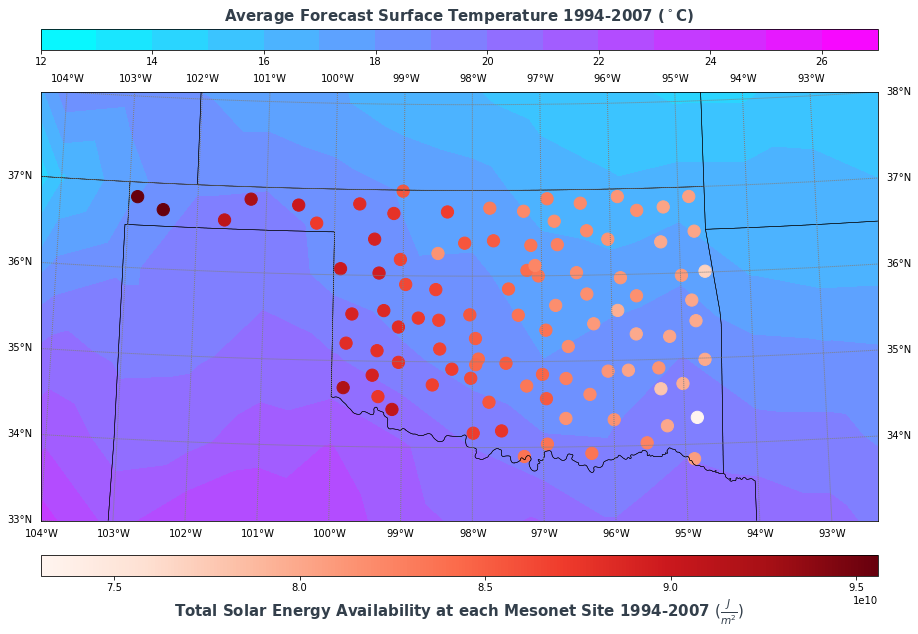

In [27]:
# Average forecast surface temperature (1994-2007)

# Initialize figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,20))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# Plot map outline and lines of latitude/longitude
lllat=33; urlat=38; lllon=-104; urlon=-92
ax = axes
m = basic_oklahoma_map(ax, lllat=lllat, urlat=urlat, lllon=lllon, urlon=urlon)
parallels = np.arange(30.,40,1.)
m.drawparallels(parallels,labels=[1,1,0,0],fontsize=10, color='grey')
meridians = np.arange(-104.,-92.,1.)
m.drawmeridians(meridians,labels=[0,0,1,1],fontsize=10, color='grey')

# Load weather forecast data and gridpoint locations
data = avg_temp['Temperature_surface'].values
lons = avg_temp['lon']
lats = avg_temp['lat']
x, y = m(lons.values, lats.values)

# Plot filled contours
clevs = range(12,28,1)
cs = plt.tricontourf(x,y,data,clevs,cmap='cool')

# Add weather cariable data colourbar
cbar = m.colorbar(cs,location='top',pad="37.5%")
cbar.set_label(r'Average Forecast Surface Temperature 1994-2007 ($^\circ$C)', fontsize=15, fontweight='black', color = '#333F4B', labelpad=-60, y=1)

# Load energy data and gridpoint locations
data = energy_sum['energy'].values
lons = energy_sum['elon']
lats = energy_sum['nlat']
x, y = m(lons.values, lats.values)

# Plot scatter points
cs = m.scatter(x,y, s=150, c=data, cmap='Reds')

# Add energy data colourbar
cbar = m.colorbar(cs,location='bottom',pad="8%")
cbar.set_label(r'Total Solar Energy Availability at each Mesonet Site 1994-2007 $(\frac{J}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

plt.show()

### Figure 12 Discussion:
- Average forecast surface temperature increases from north to south. It does not appear to be well-correlated with solar energy availability. 

In [29]:
##### Note: this includes all gridpoints, not just those directly surrounding / inside Oklahoma

# Load weather forecast data
total_prec = pd.DataFrame(list_of_dfs[0])
total_prec = total_prec.iloc[:, 2]

# Take the median of the 11 predictive models
total_prec = total_prec.groupby(by=['time','fhour', 'lat', 'lon']).median()

# Set datetime index and resample annually
total_prec = total_prec.reset_index()
total_prec = total_prec.set_index(pd.DatetimeIndex(total_prec['time']))
del total_prec['time']
total_prec = total_prec.resample('A').sum()['Total_precipitation']

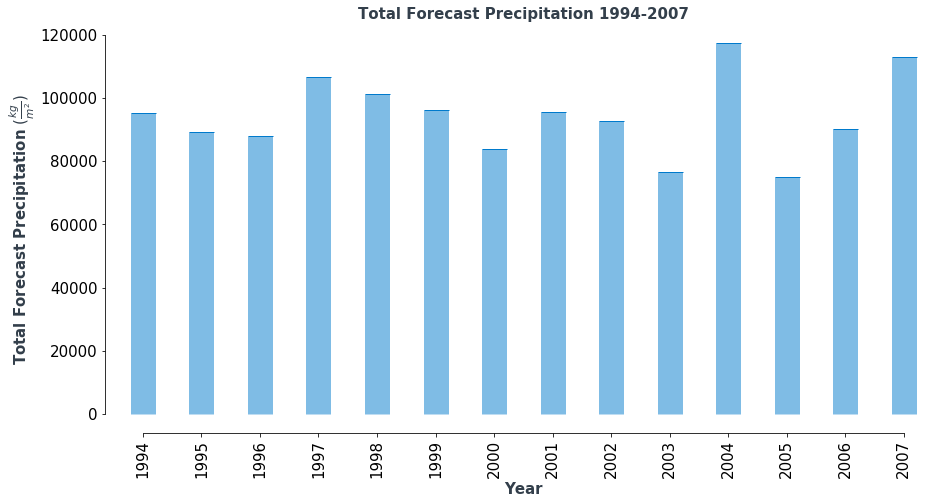

In [30]:
# Initialize figures and axes
fig, ax = plt.subplots(figsize=(15,7.5))

# Initialize x locations for west data
my_range=list(range(0,len(total_prec.index)))
    
# Plot bar lines for west data
ax.vlines(x=my_range, ymin=0, ymax=total_prec, color='#007acc', alpha=0.5, linewidth=25)

# Plot accent line at top of west bars
ax.plot(my_range, total_prec, "_", markersize=25, color='#007acc', alpha=1)

# Set axes customizations
ax.set_title(r'Total Forecast Precipitation 1994-2007', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel(r'Total Forecast Precipitation $(\frac{kg}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

ind = np.arange(len(total_energy_yearly))
ax.set_xticks(ind)
ax.set_xticklabels(('1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008'), rotation=90, fontsize=15)

ax.tick_params(labelsize=15)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

plt.savefig('Figures/total_forecast_precipitation_by_month', bbox_inches='tight', pad_inches=0.5) 

plt.show()

### Figure 13 Discussion:
- Total forecast precipitation varies year to year
- 2004 and 2007 had the most forecast precipitation - these two years had the lowest combined energy

In [30]:
# Load weather forecast data
total_prec = pd.DataFrame(list_of_dfs[0])
total_prec = total_prec.iloc[:, 2]

# Take the median of the 11 predictive models
total_prec = total_prec.groupby(by=['time','fhour', 'lat', 'lon']).median()

# Set datetime index and resample annually
total_prec = total_prec.reset_index()
total_prec = total_prec.set_index(pd.DatetimeIndex(total_prec['time']))
total_prec = total_prec.resample('M').sum()['Total_precipitation']

total_prec = total_prec.to_frame()
total_prec = total_prec.reset_index()
total_prec['month'] = total_prec.time.apply(lambda x: x.strftime('%b'))

total_prec = total_prec.groupby(by='month').sum().reset_index()

#total_prec.columns = ['month']

total_prec['month'] = pd.to_datetime(total_prec.month, format='%b', errors='coerce').dt.month
total_prec = total_prec.sort_values(by="month")
total_prec = total_prec.set_index('month')

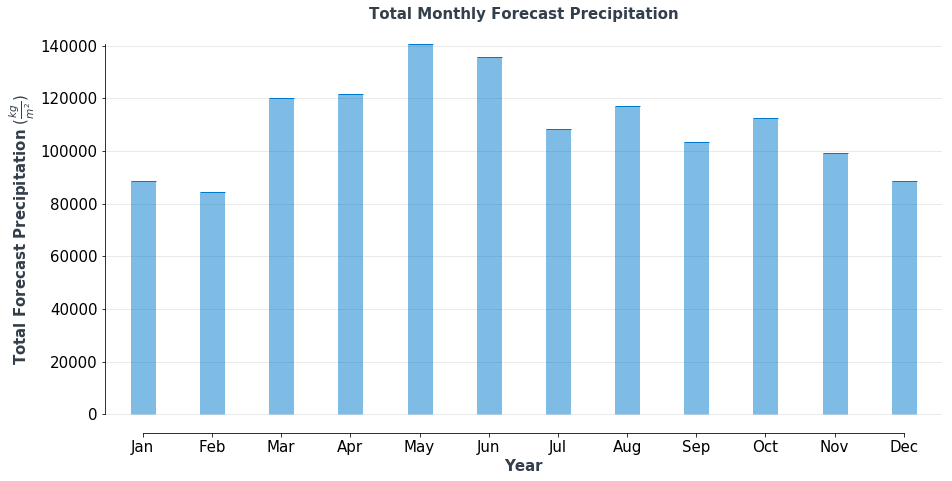

In [31]:
# Initialize figures and axes
fig, ax = plt.subplots(figsize=(15,7.5))

# Initialize x locations for west data
my_range=list(range(0,len(total_prec.index)))
    
# Plot bar lines for west data
ax.vlines(x=my_range, ymin=0, ymax=total_prec, color='#007acc', alpha=0.5, linewidth=25)

# Plot accent line at top of west bars
ax.plot(my_range, total_prec, "_", markersize=25, color='#007acc', alpha=1)

# Set titles and axes labels
ax.set_title("Total Monthly Forecast Precipitation", fontsize=15, fontweight='black', color = '#333F4B')
ax.set_xlabel('Year', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel(r'Total Forecast Precipitation $(\frac{kg}{m^2})$', fontsize=15, fontweight='black', color = '#333F4B')

# Set axes customizations
ax.set_facecolor('white')

ind = np.arange(len(total_prec))
ax.set_xticks(ind)
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), fontsize=15)

ax.grid(color='grey', alpha=0.2)
ax.xaxis.grid(False)
ax.set_axisbelow(True)

ax.tick_params(labelsize=15)

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

plt.show()

### Figure 14 Discussion:
- Forecast precipitation totals most in May and June

# Weather Forecast Variables (no energy data)

In [33]:
# Code for plotting station locations only  (no energy data) on weather variable contour plots
'''
# Plot the station locations
stat_lons = stations['elon']
stat_lats = stations['nlat']
x2, y2 = m(stat_lons.values, stat_lats.values)
cs2 = m.scatter(x2,y2, s=20, color='black')

# Add station legend
plt.text(0.125,0.185, r'Mesonet Station:', fontsize=12, transform=plt.gcf().transFigure)
plt.text(0.24,0.185, r'$\bullet$', fontsize=20, transform=plt.gcf().transFigure)

plt.show()
'''

"\n# Plot the station locations\nstat_lons = stations['elon']\nstat_lats = stations['nlat']\nx2, y2 = m(stat_lons.values, stat_lats.values)\ncs2 = m.scatter(x2,y2, s=20, color='black')\n\n# Add station legend\nplt.text(0.125,0.185, r'Mesonet Station:', fontsize=12, transform=plt.gcf().transFigure)\nplt.text(0.24,0.185, r'$\x08ullet$', fontsize=20, transform=plt.gcf().transFigure)\n\nplt.show()\n"